# Carpet Claim Data Analysis
Investigate the defects in the delamination testing data using one monthe data (Aug 2017) at various intervals

In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import os, inspect
import csv
%matplotlib inline 
import pylab
import matplotlib.pylab as plt
import matplotlib.image as img
import scipy.stats as stats
import seaborn as sns
from IPython.core.display import HTML 
from sklearn.preprocessing import scale
from bokeh.io import show, output_file
from bokeh.plotting import figure
#from bokeh.charts import Bar, BoxPlot


# Define functions

In [2]:
#define a function to visualize results
def _plot_value_series(self, dt, factor, yName, iplot, varDefect=None):
    #self is data array
    nrow = len(self)
    #Feature
    self_max = np.max(self)
    self_min = np.min(self)
    self_mu = np.mean(self)
    self_std = np.std(self)
    upper_limit = self_mu + factor * self_std;
    lower_limit = self_mu - factor * self_std;
    
    #create a vector
    ts = range(nrow)
 
    #check timepoints
    len_time = len(dt)
    if len_time > nrow or len_time < nrow:
        dt = ts
        
    fig = plt.figure(figsize=(11,4))    
    ax = plt.subplot(111)  
    
     #plt.plot(dt,X,'k-')
    s1 = np.random.rand(*dt.shape) * 80 + 50
    plt.scatter(dt,self, s1, c="k", alpha = 0.8)  
    #plt.plot(dt,self,'k-')
    
    #####horizontal line
    upper_limit_data = np.array([upper_limit for i in range(len(dt))])
    plt.plot(dt, upper_limit_data, 'r--', label='Upper Limit') 

    lower_limit_data = np.array([lower_limit for i in range(len(dt))])
    plt.plot(dt, lower_limit_data, 'g--', label='Lower Limit') 
    
    #ax.axhline(y=upper_limit, xmin=dt[0], xmax = dt[len(dt)-1],color = 'b', label='Upper limit')
    #ax.axhline(y=lower_limit, xmin=dt[0], xmax = dt[len(dt)-1],color='g', label='Lower limit')
    plt.ylabel(yName)
    plt.xlabel('Time')
    
    # retrieving the indices where "sng > max" using np.where    
    upperIndex = []
    upperCnt = 0.0
    lowerIndex = []
    lowerCnt = 0.0
    for index, item in enumerate(self):        
        if item > upper_limit:
            upperCnt += 1.0
            upperIndex.append(index)
            plt.plot(dt[index],item, 'bs') 
        else:
            if item < lower_limit:
                lowerCnt += 1.0
                lowerIndex.append(index)
                plt.plot(dt[index],item, 'ms')           
            
        if varDefect is not None and varDefect[index] > 0:
            s = np.pi * varDefect[index]**2 #np.random.rand(*dt.shape) * 80 + 50
            plt.scatter(dt[index],item,s, c="r", alpha = 0.5)         
            
    # Now add the legend with some customizations.
    legend = ax.legend(loc='best', shadow=True)

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.0)  # the legend line width
    
    plt.show()
    
    # display the failure data points
    if (iplot == 1) and (upperCnt > 0.0):
        print('Number of above upper limit points = ', upperCnt)
        print('Above upperlimit points:', upperIndex)        
    
    if (iplot == 1) and (lowerCnt > 0.0):
        print('Number of below lowerlimit points = ', lowerCnt)
        print('Below lowerlimit points:', lowerIndex)    

In [3]:
#Visualizing Interrelationships between Attributes - scatter
def _plot_multivariate(self):
    plt.figure(figsize=(14,14))
    pd.plotting.scatter_matrix(self, diagonal="kde") 
    plt.tight_layout()
    plt.show()

In [4]:
#Visualizing Attribute and Label Correlations Using a Heat Map
#calculate correlations between real-valued attributes
def _plot_heatmap(self):
    xcorMat = pd.DataFrame(self.corr())
    #visualize correlations using heatmap
    plt.pcolor(xcorMat)
    plt.show() 

In [5]:
# plot quantile-quantile of data   
def _plot_QQ(self):    
    #plot quantile-quantile of a timeseries
    stats.probplot(self, dist="norm", plot=plt)
    plt.show() 

In [6]:
def _plot_boxplot(self):
    #plot box plot of one variable or matrix
    plt.figure(figsize=(11,11)) 
    plt.boxplot(self, 0, 'rD', 0, 0.75)    
    plt.show()

In [7]:
def _timeseries_plot(self):
    #plot time series of univaraite or multivariable
    plt.figure(figsize=(15,4))
    ax = self.plot()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()
    plt.show()

In [8]:
# clean latex type
def _read_tagData(dataModel, tag, thred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] == thred, :]
    #print(dataModel.loc[:,['GFROLL', 'GFLTYP','delamIndex', 'delamMin']], len(dataModel_output.GFROLL))
    return dataModel_output

In [9]:
def _read_upper(dataModel, tag, upperThred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] <= upperThred,:]
    return dataModel_output
        
def _read_lower(dataModel, tag, lowerThred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] >= lowerThred,:]
    return dataModel_output

def _drop_rows(dataModel, tag, thred):
    #drop other GFTYPE
    # thred can be a numerical or string   
    
    dataModel_rem = dataModel[dataModel[tag] != thred]
    return dataModel_rem

In [10]:
from collections import Counter
def class_info(classes):
    counts = Counter(classes)
    total = sum(list(counts.values()))
  
    for cls in counts.keys():
        print("%6s: % 7d  =  % 5.1f%%" % (cls, counts[cls], counts[cls]/total*100))


In [11]:
 def _create_filename(path, fname, affix = '.csv'):
        # create new file name
                    
        output_name = fname + affix        
        foutput_name = os.path.join(path, '', output_name)
              
        return foutput_name

In [12]:
# set working directory
#curPath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
#parentDir = os.path.split(curPath)[0];
parentDir = 'C:/Users/E154709/Desktop/Mohawk/Claims'
os.chdir(parentDir)

outputPath = parentDir + '/Output/'
if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    
codePath = parentDir + '/Code/'
if not os.path.exists(codePath):
    os.mkdir(codePath)
    
dataPath = parentDir + '/Data/'
if not os.path.exists(dataPath):
    os.mkdir(dataPath)


In [13]:
#create data file
    
fname = 'rawData'
frawData = _create_filename(dataPath,fname)
print(frawData)

C:/Users/E154709/Desktop/Mohawk/Claims/Data/rawData.csv


# Import and Consolidate Claim Data 

Run this section only if you have not consolidated the raw data. Otherwise, directly go to the section of claim data processing

In [68]:
# Read Claims Data
import chardet
    
Claim_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims.csv'
ClaimsData = pd.read_csv(Claim_dataPath, encoding='latin1')  # Read the claims data

ClaimReason_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Reason.csv'
ClaimReason = pd.read_csv(ClaimReason_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimStatus_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Status.csv'
ClaimStatus = pd.read_csv(ClaimStatus_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimType_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Type.csv'
ClaimType = pd.read_csv(ClaimType_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimCustomer_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/SLS_Customer.csv'
ClaimCustomer = pd.read_csv(ClaimCustomer_dataPath, encoding='latin1')  # Read the claimReason data

In [69]:
#check the claim data
print(ClaimsData.describe())
print(ClaimsData.shape)
print(ClaimsData.columns.values)

       FACT_CUSTOMER_CLAIMS_PK  DIM_DIVISION_CUSTOMER_PK  \
count             3.114910e+05              3.114910e+05   
mean              1.238682e+07              2.042229e+06   
std               7.553653e+05              2.644398e+05   
min               1.747000e+03              1.257705e+06   
25%               1.235823e+07              1.984710e+06   
50%               1.244263e+07              2.155343e+06   
75%               1.252643e+07              2.212648e+06   
max               1.261002e+07              2.318022e+06   

       DIM_DIVISION_CUSTOMER_GK  CLAIM_DATE_PK  CLAIM_STATUS_DATE_PK  \
count             311491.000000   3.114910e+05          3.114910e+05   
mean              282254.679564   2.017000e+07          2.017061e+07   
std                69499.110024   3.625091e+04          3.353591e+02   
min                54987.000000  -1.000000e+00          2.010052e+07   
25%               242550.000000   2.017030e+07          2.017040e+07   
50%               268953.00

In [70]:
#check the claim data
print(ClaimReason.describe())
print(ClaimReason.shape)
print(ClaimReason.columns.values)

       DIM_CLAIM_REASON_PK  DIM_CLAIM_REASON_GK
count             566.0000           566.000000
mean              280.5000           281.496466
std               163.5344           163.540515
min                -2.0000            -2.000000
25%               139.2500           140.250000
50%               280.5000           281.500000
75%               421.7500           422.750000
max               563.0000           564.000000
(566, 13)
['DIM_CLAIM_REASON_PK' 'DIM_CLAIM_REASON_GK' 'CLAIM_REASON_CD'
 'CLAIM_REASON_DESC' 'CLAIM_REASON_SHORT_DESC' 'CLAIM_DEPARTMENT_CD'
 'QUALITY_RELATED_CD' 'ENTERPRISE_ENTITY_CD' 'SOURCE_SYSTEM_CD'
 'DELETE_IND' 'CREATE_DTM' 'UPDATE_DTM' 'LANDING_DTM']


In [71]:
Claims_Reason = ClaimsData.join(ClaimReason, rsuffix = '_reason')
print(Claims_Reason.shape)

(311491, 53)


In [72]:
Claims_Status = Claims_Reason.join(ClaimStatus, rsuffix = '_status')
print(Claims_Status.shape)

(311491, 71)


In [73]:
Claims_Type = Claims_Status.join(ClaimType, rsuffix = '_type')
print(Claims_Type.shape)

(311491, 86)


In [74]:
#ClaimCustomer = ClaimCustomer.rename(columns = {'SOLD_TO_CUSTOMER_GK':'PRIMARY_CUSTOMER_GK', 'SOLD_TO_CUSTOMER_PK':'PRIMARY_CUSTOMER_PK'})
ClaimCustomer = ClaimCustomer.rename(columns = {'SOLD_TO_CUSTOMER_GK':'PRIMARY_CUSTOMER_GK'})
tagList = list(ClaimCustomer.head(1).columns.values)
print(tagList)

['FISCAL_YR_NUM', 'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'PRIMARY_CUSTOMER_GK', 'CUSTOMER_NUM', 'CUSTOMER_SUFFIX_NUM', 'CUSTOMER_NAME', 'DIVISION_CD', 'SLS']


In [75]:
Claims_Customer = Claims_Type.join(ClaimCustomer, rsuffix = '_customer')
print(Claims_Customer.shape)

(311491, 95)


In [76]:
tagList = list(Claims_Customer.head(1).columns.values)
print(tagList, len(tagList))

['FACT_CUSTOMER_CLAIMS_PK', 'TRX_CUSTOMER_CLAIMS_ID', 'DIM_DIVISION_CUSTOMER_PK', 'DIM_DIVISION_CUSTOMER_GK', 'CLAIM_DATE_PK', 'CLAIM_STATUS_DATE_PK', 'CLAIM_ENTRY_DATE_PK', 'INVOICE_DATE_PK', 'CREDIT_MEMO_DATE_PK', 'DEBIT_MEMO_DATE_PK', 'DIM_CLAIM_COMMENTS_PK', 'DIM_CLAIM_TYPE_PK', 'DIM_CLAIM_STATUS_PK', 'DIM_CLAIM_REASON_PK', 'DIM_FINISHED_PRODUCT_SELL_PK', 'DIM_FINISHED_PRODUCT_SELL_GK', 'PRODUCT_TYPE_PK', 'DIM_MISC_CHARGE_PK', 'DIM_SALES_ORG_PK', 'DIM_SALES_ORG_GK', 'CURRENT_SALES_ORG_PK', 'CURRENT_SALES_ORG_GK', 'PRIMARY_CUSTOMER_PK', 'PRIMARY_CUSTOMER_GK', 'SECURITY_TERRITORY_MANAGER_CD', 'CLAIM_NUM', 'CLAIM_SEQUENCE_NUM', 'INVOICE_NUM', 'INVOICE_SEQUENCE_NUM', 'CREDIT_MEMO_NUM', 'CUSTOMER_CONTACT_NAME', 'CLAIMS_ANALYST_CD', 'ENTERED_BY_TXT', 'TOTAL_CLAIMS_DOLLAR_AMT', 'ENTERPRISE_ENTITY_CD', 'SOURCE_SYSTEM_CD', 'CREATE_DTM', 'UPDATE_DTM', 'SOURCE_DTM', 'LANDING_DTM', 'DIM_CLAIM_REASON_PK_reason', 'DIM_CLAIM_REASON_GK', 'CLAIM_REASON_CD', 'CLAIM_REASON_DESC', 'CLAIM_REASON_SHORT_

In [77]:
tagList1 = [x for x in tagList if "_reason" not in x]
tagList2 = [x for x in tagList1 if "_status" not in x]
tagList3 = [x for x in tagList2 if "_type" not in x]
tagList = [x for x in tagList3 if "_customer" not in x]
print(tagList, len(tagList))

['FACT_CUSTOMER_CLAIMS_PK', 'TRX_CUSTOMER_CLAIMS_ID', 'DIM_DIVISION_CUSTOMER_PK', 'DIM_DIVISION_CUSTOMER_GK', 'CLAIM_DATE_PK', 'CLAIM_STATUS_DATE_PK', 'CLAIM_ENTRY_DATE_PK', 'INVOICE_DATE_PK', 'CREDIT_MEMO_DATE_PK', 'DEBIT_MEMO_DATE_PK', 'DIM_CLAIM_COMMENTS_PK', 'DIM_CLAIM_TYPE_PK', 'DIM_CLAIM_STATUS_PK', 'DIM_CLAIM_REASON_PK', 'DIM_FINISHED_PRODUCT_SELL_PK', 'DIM_FINISHED_PRODUCT_SELL_GK', 'PRODUCT_TYPE_PK', 'DIM_MISC_CHARGE_PK', 'DIM_SALES_ORG_PK', 'DIM_SALES_ORG_GK', 'CURRENT_SALES_ORG_PK', 'CURRENT_SALES_ORG_GK', 'PRIMARY_CUSTOMER_PK', 'PRIMARY_CUSTOMER_GK', 'SECURITY_TERRITORY_MANAGER_CD', 'CLAIM_NUM', 'CLAIM_SEQUENCE_NUM', 'INVOICE_NUM', 'INVOICE_SEQUENCE_NUM', 'CREDIT_MEMO_NUM', 'CUSTOMER_CONTACT_NAME', 'CLAIMS_ANALYST_CD', 'ENTERED_BY_TXT', 'TOTAL_CLAIMS_DOLLAR_AMT', 'ENTERPRISE_ENTITY_CD', 'SOURCE_SYSTEM_CD', 'CREATE_DTM', 'UPDATE_DTM', 'SOURCE_DTM', 'LANDING_DTM', 'DIM_CLAIM_REASON_GK', 'CLAIM_REASON_CD', 'CLAIM_REASON_DESC', 'CLAIM_REASON_SHORT_DESC', 'CLAIM_DEPARTMENT_CD', 

In [78]:
# save data into csv file
ClaimData = Claims_Customer[tagList]
ClaimData.to_csv(frawData)
print(ClaimData.shape)

(311491, 74)


# Claim Data Processing
Building the recommendation/scoring model from Customer angle. Factors used in the modeling:
- Customer Name
- SLS = Sales
- TOTAL_CLAIMS_DOLLAR_AMT = $Claims

Derivated variables:
 - Total claims each customer in past year = #claim
 - Dollars each claim each customer = $/claim
 
 - Total sales each customer = SLS
 - Dollars per sale each customer = $/sale
 - Claim to sale ratio = claim/SLS

In [79]:
# read consildated claim data
ClaimData = pd.read_csv(frawData, encoding='latin1') # Read the data
print(ClaimData.columns)

C:\anaconda35\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (42,43,44,45,46,47,49,50,51,52,53,54,55,56,60,61,62,63,64,65,66,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Unnamed: 0', 'FACT_CUSTOMER_CLAIMS_PK', 'TRX_CUSTOMER_CLAIMS_ID',
       'DIM_DIVISION_CUSTOMER_PK', 'DIM_DIVISION_CUSTOMER_GK', 'CLAIM_DATE_PK',
       'CLAIM_STATUS_DATE_PK', 'CLAIM_ENTRY_DATE_PK', 'INVOICE_DATE_PK',
       'CREDIT_MEMO_DATE_PK', 'DEBIT_MEMO_DATE_PK', 'DIM_CLAIM_COMMENTS_PK',
       'DIM_CLAIM_TYPE_PK', 'DIM_CLAIM_STATUS_PK', 'DIM_CLAIM_REASON_PK',
       'DIM_FINISHED_PRODUCT_SELL_PK', 'DIM_FINISHED_PRODUCT_SELL_GK',
       'PRODUCT_TYPE_PK', 'DIM_MISC_CHARGE_PK', 'DIM_SALES_ORG_PK',
       'DIM_SALES_ORG_GK', 'CURRENT_SALES_ORG_PK', 'CURRENT_SALES_ORG_GK',
       'PRIMARY_CUSTOMER_PK', 'PRIMARY_CUSTOMER_GK',
       'SECURITY_TERRITORY_MANAGER_CD', 'CLAIM_NUM', 'CLAIM_SEQUENCE_NUM',
       'INVOICE_NUM', 'INVOICE_SEQUENCE_NUM', 'CREDIT_MEMO_NUM',
       'CUSTOMER_CONTACT_NAME', 'CLAIMS_ANALYST_CD', 'ENTERED_BY_TXT',
       'TOTAL_CLAIMS_DOLLAR_AMT', 'ENTERPRISE_ENTITY_CD', 'SOURCE_SYSTEM_CD',
       'CREATE_DTM', 'UPDATE_DTM', 'SOURCE_DTM', 'LANDING_DTM',
  

(196803, 75)


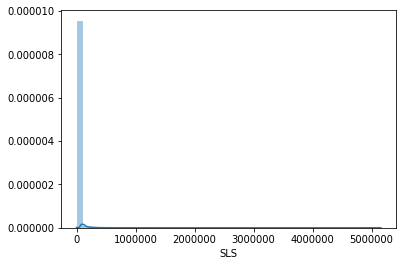

In [80]:
# filter data to have SLS > 10
customerData_SLS = ClaimData[ClaimData["SLS"]>100]
sns.distplot(customerData_SLS["SLS"])
print(customerData_SLS.shape)

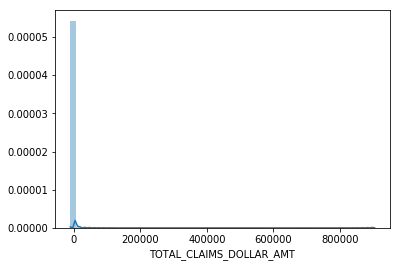

In [81]:
sns.distplot(customerData_SLS["TOTAL_CLAIMS_DOLLAR_AMT"])

C:\anaconda35\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(180813, 75)


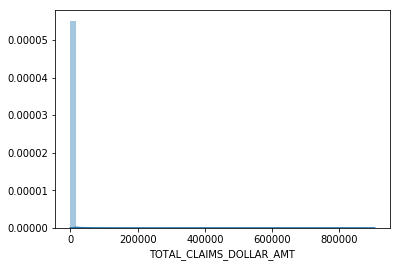

In [82]:
# filter data to have TOTAL_CLAIMS_DOLLAR_AMT > 1
customerData_AMT = customerData_SLS[ClaimData['TOTAL_CLAIMS_DOLLAR_AMT']>0]
sns.distplot(customerData_AMT['TOTAL_CLAIMS_DOLLAR_AMT'])
print(customerData_AMT.shape)

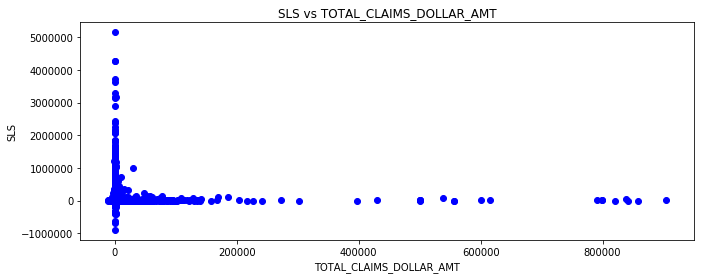

In [83]:
def _plot_scatter(data, xTag, yTag):
    # Set style of scatterplot
    #sns.set_context("notebook", font_scale=1.1)
    #sns.set_style("ticks")
    from itertools import cycle
    color_gen = cycle(('blue', 'lightgreen', 'red', 'purple', 'gray', 'cyan'))

    # Create scatterplot of dataframe
    fig = plt.figure(figsize=(11,4)) 
    plt.scatter(data[xTag], # Horizontal axis
               data[yTag], # Vertical axis
               c = next(color_gen))

    # Set title
    plt.title(yTag + ' vs ' + xTag)

    # Set x-axis label
    plt.xlabel(xTag)

    # Set y-axis label
    plt.ylabel(yTag)
    plt.show()

xTag = 'TOTAL_CLAIMS_DOLLAR_AMT'
yTag = 'SLS'
_plot_scatter(ClaimData, xTag, yTag)

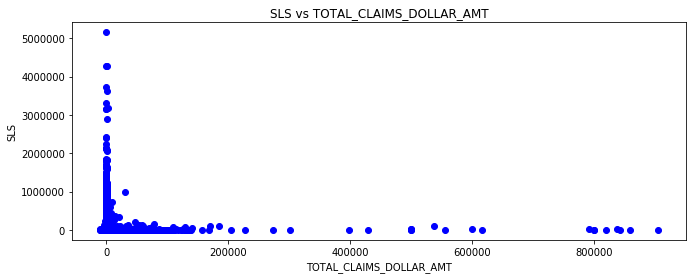

In [84]:
_plot_scatter(customerData_SLS, xTag, yTag)

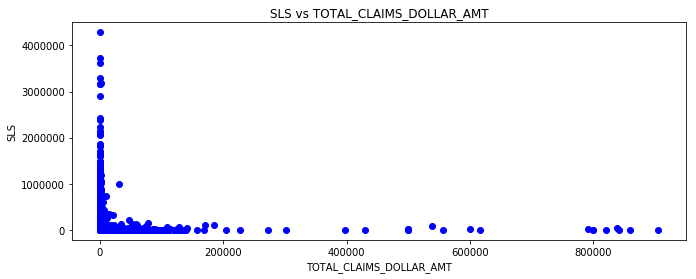

In [85]:
_plot_scatter(customerData_AMT, xTag, yTag)

In [86]:
index_nan = ClaimData['TOTAL_CLAIMS_DOLLAR_AMT'].index[ClaimData['TOTAL_CLAIMS_DOLLAR_AMT']<100]
print(index_nan.shape)

(175460,)


In [87]:
index_nan2 = customerData_SLS['TOTAL_CLAIMS_DOLLAR_AMT'].index[customerData_SLS['TOTAL_CLAIMS_DOLLAR_AMT']<0]
print(index_nan2.shape)

(8904,)


In [88]:
customerData = customerData_AMT.groupby(['CUSTOMER_NAME', 'TOTAL_CLAIMS_DOLLAR_AMT']).sum()
print(customerData.shape)

(180231, 40)


In [89]:
ClaimData = customerData_AMT
#create a pivot table to reshape the data, using sum or count function
claimDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='TOTAL_CLAIMS_DOLLAR_AMT', aggfunc=sum)
print(claimDollar.head(2), claimDollar.shape)

                TOTAL_CLAIMS_DOLLAR_AMT
CUSTOMER_NAME                          
067 / STERLING                     0.01
072366 BC LTD                   5369.75 (25151, 1)


In [90]:
claimDollar_na = claimDollar.dropna(axis=0, how = 'any')
print(claimDollar_na.shape)

(25151, 1)


In [91]:
#create a pivot table to reshape the data, using sum or count function
saleNumber = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=len)
saleNumber = saleNumber.rename(columns = {'SLS':'NumberSales'})
saleDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=sum)
print(saleDollar.head(2), saleDollar.shape)

                    SLS
CUSTOMER_NAME          
067 / STERLING  1103.37
072366 BC LTD   6397.65 (25151, 1)


In [92]:
saleDollar_na = saleDollar.dropna(axis = 0, how = 'any')
print(saleDollar_na.shape)

(25151, 1)


In [93]:
saleData = pd.concat([saleDollar_na, saleNumber], axis=1, join_axes=[saleDollar_na.index])
saleData['DollarPerSale'] = saleData['SLS']/saleData['NumberSales']
print(saleData.shape, saleData.head(2))

(25151, 3)                     SLS  NumberSales  DollarPerSale
CUSTOMER_NAME                                      
067 / STERLING  1103.37          1.0      1103.3700
072366 BC LTD   6397.65          4.0      1599.4125


In [94]:
customerData = pd.concat([saleData, claimDollar_na], axis=1, join_axes=[saleData.index])
customerData['ClaimRatio'] = customerData['TOTAL_CLAIMS_DOLLAR_AMT']/customerData['SLS']
print(customerData.shape, customerData.head(2))

(25151, 5)                     SLS  NumberSales  DollarPerSale  TOTAL_CLAIMS_DOLLAR_AMT  \
CUSTOMER_NAME                                                                  
067 / STERLING  1103.37          1.0      1103.3700                     0.01   
072366 BC LTD   6397.65          4.0      1599.4125                  5369.75   

                ClaimRatio  
CUSTOMER_NAME               
067 / STERLING    0.000009  
072366 BC LTD     0.839332  


In [95]:
#create a pivot table to reshape the data, using sum or count function
claimCnt = ClaimData.pivot_table(index='CUSTOMER_NAME', values='TOTAL_CLAIMS_DOLLAR_AMT', aggfunc=len)
claimCnt = claimCnt.rename(columns = {'TOTAL_CLAIMS_DOLLAR_AMT':'Total_Claims'})
print(claimCnt.head(2), claimCnt.shape)

                Total_Claims
CUSTOMER_NAME               
067 / STERLING           1.0
072366 BC LTD            4.0 (25151, 1)


In [96]:
# join count claim
modelData = pd.concat([customerData, claimCnt], axis=1, join_axes=[customerData.index])
modelData['DollarPerClaim'] = modelData['TOTAL_CLAIMS_DOLLAR_AMT']/modelData['Total_Claims']
print(modelData.shape, modelData.head(2))

(25151, 7)                     SLS  NumberSales  DollarPerSale  TOTAL_CLAIMS_DOLLAR_AMT  \
CUSTOMER_NAME                                                                  
067 / STERLING  1103.37          1.0      1103.3700                     0.01   
072366 BC LTD   6397.65          4.0      1599.4125                  5369.75   

                ClaimRatio  Total_Claims  DollarPerClaim  
CUSTOMER_NAME                                             
067 / STERLING    0.000009           1.0          0.0100  
072366 BC LTD     0.839332           4.0       1342.4375  


In [97]:
modelData.reset_index(inplace=True)
print(modelData.head(20), modelData.shape)

                     CUSTOMER_NAME        SLS  NumberSales  DollarPerSale  \
0                   067 / STERLING    1103.37          1.0    1103.370000   
1                    072366 BC LTD    6397.65          4.0    1599.412500   
2                    077409 BC LTD    2039.76          1.0    2039.760000   
3                 0956404 B.C. LTD    2596.16          1.0    2596.160000   
4                  1 TO 1 WIRELESS    1005.11          1.0    1005.110000   
5                  1 UP FLOORS LLC  502028.74         12.0   41835.728333   
6     1-2-3 DECORATORS FASHION INC   11672.47          5.0    2334.494000   
7                 1-2-3 FLOORS INC   22644.36         10.0    2264.436000   
8   10 WILMINGTON PLACE RETIREMENT   22199.46          1.0   22199.460000   
9               1010 INTERIORS INC   23666.54          6.0    3944.423333   
10      101154550 SASKATCHEWAN LTD   23443.92          6.0    3907.320000   
11                 1072346 BC LTD.   15917.01          7.0    2273.858571   

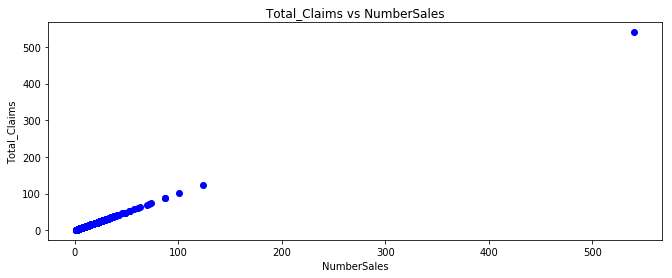

In [65]:
xTag = 'NumberSales'
yTag = 'Total_Claims'
_plot_scatter(modelData, xTag, yTag)

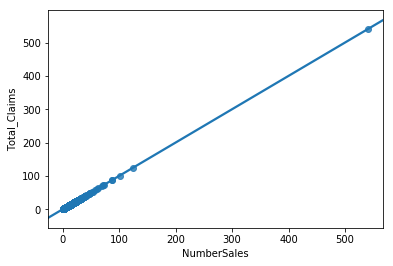

In [66]:
 ax = sns.regplot(x=xTag, y=yTag, data=modelData)

# Check raw data for more factors

In [35]:
#create a pivot table to reshape the data, using sum or count function
claimReason = ClaimData.pivot_table(index='DIM_CLAIM_REASON_PK', values='TOTAL_CLAIMS_DOLLAR_AMT', aggfunc=sum)
print(claimReason.head(10), claimReason.shape)

                     TOTAL_CLAIMS_DOLLAR_AMT
DIM_CLAIM_REASON_PK                         
-1                                4518787.45
 5                                 351805.22
 8                                   3353.82
 11                                 86946.42
 12                                135850.80
 13                               2489271.09
 14                                100061.68
 15                                155214.41
 16                               1051640.68
 17                                 71798.07 (390, 1)


In [36]:
critTags = ['TOTAL_CLAIMS_DOLLAR_AMT','PRIMARY_CUSTOMER_PK', 'PRODUCT_TYPE_PK','CUSTOMER_NAME',
            'DIM_CLAIM_REASON_PK','DIM_CLAIM_TYPE_PK', 'CLAIM_REASON_SHORT_DESC', 'QUALITY_RELATED_CD', 'CUSTOMER_NAME', 'SLS']
critClaim = ClaimData[critTags]
print(critClaim.shape)

(180813, 10)


In [37]:
print(critClaim.head(2))

   TOTAL_CLAIMS_DOLLAR_AMT  PRIMARY_CUSTOMER_PK  PRODUCT_TYPE_PK  \
1                    250.0              2056197               -1   
2                   5419.8              2019950               -1   

                    CUSTOMER_NAME  DIM_CLAIM_REASON_PK  DIM_CLAIM_TYPE_PK  \
1  LOWES OF OSAGE BEACH     #1147                  101                  8   
2           WEITZ SUPLY CHAIN LLC                  101                  8   

  CLAIM_REASON_SHORT_DESC    QUALITY_RELATED_CD  \
1    Not Applicable (N/A)  Not Applicable (N/A)   
2                CLOPLACE                     Y   

                    CUSTOMER_NAME        SLS  
1  LOWES OF OSAGE BEACH     #1147    9573.83  
2           WEITZ SUPLY CHAIN LLC  100700.24  


In [38]:
list_unique = set(ClaimData.DIM_CLAIM_TYPE_PK)
uniqueCnt = len(list_unique)
print(uniqueCnt)  

38


In [39]:
# unique customer name
list_unique = set(ClaimData.CUSTOMER_NAME)
uniqueCnt = len(list_unique)
print(uniqueCnt)

25151


In [40]:
list_unique = set(critClaim.DIM_CLAIM_REASON_PK)
uniqueCnt = len(list_unique)
print(uniqueCnt) 

390


In [41]:
#create a pivot table to reshape the data, using sum or count function
claimData_type = critClaim.pivot_table(index='DIM_CLAIM_TYPE_PK',columns='QUALITY_RELATED_CD', values='TOTAL_CLAIMS_DOLLAR_AMT', aggfunc=len)
print(claimData_type)

QUALITY_RELATED_CD     N  Not Applicable (N/A)  Unknown     V      Y
DIM_CLAIM_TYPE_PK                                                   
1                    9.0                   NaN      NaN   2.0    2.0
5                    2.0                   NaN      NaN   NaN    NaN
8                   78.0                   1.0      1.0  11.0  132.0
10                  87.0                   NaN      NaN  10.0    1.0
11                   NaN                   NaN      NaN   1.0    NaN
17                  81.0                   NaN      NaN  14.0   46.0
24                   1.0                   NaN      NaN   NaN    NaN


In [42]:
statusTags = ['CLAIM_APPROVED_IND','CLAIM_PENDING_IND','CLAIM_ISSUED_IND','CLAIM_DECLINED_IND',
              'CLAIM_OPEN_IND','CLAIM_STATUS_TYPE_CD','CLAIM_STATUS_TYPE_SHORT_DESC']
statusData = ClaimData[statusTags]
print(statusData.shape)

(180813, 7)


In [43]:
print(statusData.head(2))

  CLAIM_APPROVED_IND CLAIM_PENDING_IND CLAIM_ISSUED_IND CLAIM_DECLINED_IND  \
1                  N                 N                N                  N   
2                  N                 N                N                  N   

  CLAIM_OPEN_IND  CLAIM_STATUS_TYPE_CD CLAIM_STATUS_TYPE_SHORT_DESC  
1              N               DELETED                      DELETED  
2              N  Not Applicable (N/A)         Not Applicable (N/A)  


# Visualization of modeling data

In [44]:
print(modelData.shape, modelData.head(2))

(25151, 8)     CUSTOMER_NAME      SLS  NumberSales  DollarPerSale  \
0  067 / STERLING  1103.37          1.0      1103.3700   
1   072366 BC LTD  6397.65          4.0      1599.4125   

   TOTAL_CLAIMS_DOLLAR_AMT  ClaimRatio  Total_Claims  DollarPerClaim  
0                     0.01    0.000009           1.0          0.0100  
1                  5369.75    0.839332           4.0       1342.4375  


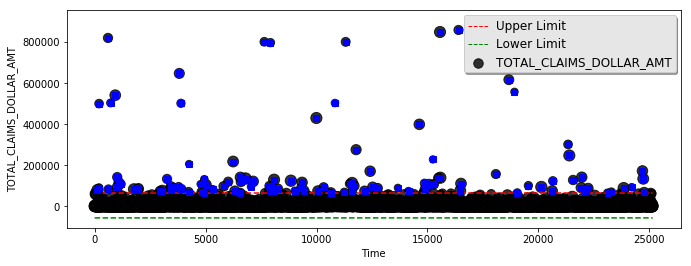

Number of above upper limit points =  110.0
Above upperlimit points: [129, 195, 201, 603, 625, 719, 929, 1019, 1026, 1087, 1174, 1772, 1952, 1977, 2948, 3050, 3263, 3425, 3444, 3548, 3783, 3816, 3887, 3890, 4236, 4255, 4775, 4828, 4916, 4944, 5022, 5327, 5815, 6021, 6243, 6319, 6568, 6571, 6592, 6801, 7047, 7145, 7650, 7877, 7890, 7926, 7951, 8088, 8098, 8244, 8845, 9017, 9298, 9349, 9425, 9994, 10063, 10321, 10646, 10833, 11252, 11316, 11500, 11604, 11610, 11697, 11785, 12166, 12418, 12529, 12756, 13667, 14147, 14634, 14868, 14902, 15073, 15248, 15287, 15497, 15567, 15582, 16401, 16479, 16513, 18084, 18669, 18923, 19050, 19550, 19794, 20135, 20622, 20652, 21339, 21395, 21565, 21632, 21928, 21957, 22066, 22145, 22241, 23118, 23286, 23846, 24210, 24691, 24728, 24768]


In [45]:
#sns.lmplot(x="SLS", y="ClaimRatio", data=modelData, hue="ClaimRatio", fit_reg=False, size = 8);
#series plot over three sigma

yName = "TOTAL_CLAIMS_DOLLAR_AMT"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

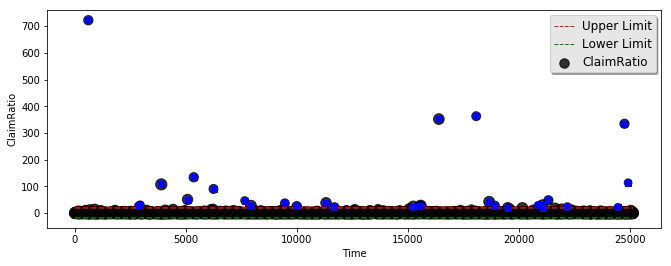

Number of above upper limit points =  29.0
Above upperlimit points: [603, 2885, 2943, 3890, 5074, 5353, 6244, 7650, 7930, 9460, 9994, 11316, 11697, 15248, 15567, 15582, 16401, 18084, 18669, 18923, 19507, 20877, 21071, 21104, 21339, 22194, 24474, 24768, 24931]


In [46]:
yName = "ClaimRatio"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [47]:
# ClaimAMT = 0
CR0 = modelData[modelData["ClaimRatio"]==0]
print(CR0.shape)

(0, 8)


In [50]:
LargeCR = modelData[modelData["ClaimRatio"] > 1]
print(LargeCR.shape)

(1140, 8)


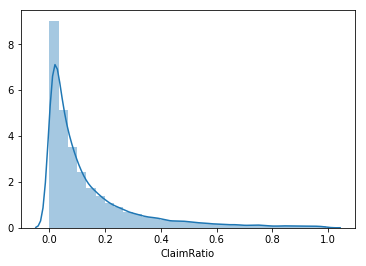

In [51]:
modelData_tmp = modelData[modelData['ClaimRatio'] < 1]
data = modelData_tmp['ClaimRatio']
sns.distplot(data, bins=30)
plt.show()

In [52]:
LargeDPS= modelData[modelData["DollarPerSale"] > 1000]
print(LargeDPS.shape)

(22216, 8)


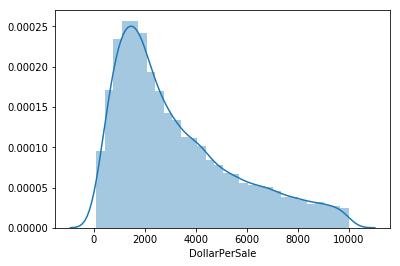

In [53]:
tag = 'DollarPerSale'
modelData_tmp = modelData[modelData[tag] < 10000]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

(4223, 8)


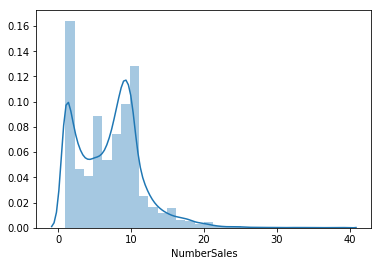

In [62]:
tag = 'NumberSales'
LargeS= modelData[modelData[tag] > 10]
print(LargeS.shape)

modelData_tmp = modelData[modelData[tag] < 40]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [54]:
LargeDPC= modelData[modelData["DollarPerClaim"] > 1000]
print(LargeDPC.shape)

(2716, 8)


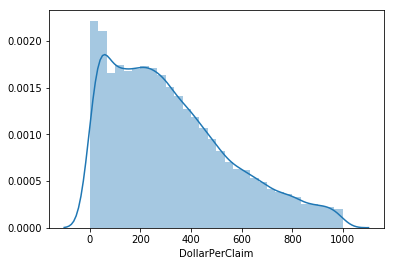

In [55]:
tag = 'DollarPerClaim'
modelData_tmp = modelData[modelData[tag] < 1000]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

(4223, 8)


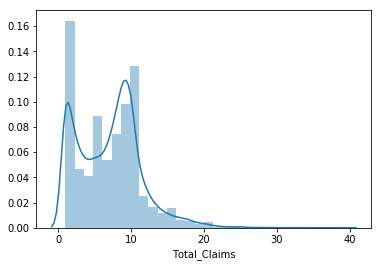

In [63]:
tag = 'Total_Claims'
LargeC= modelData[modelData[tag] > 10]
print(LargeC.shape)

modelData_tmp = modelData[modelData[tag] < 40]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

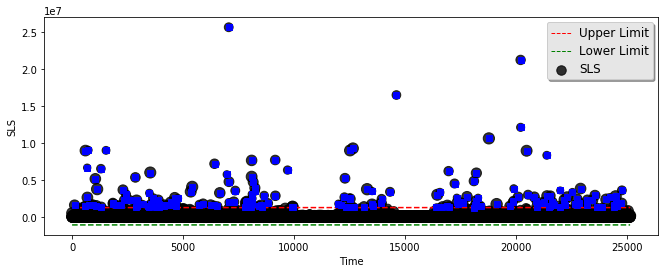

Number of above upper limit points =  183.0
Above upperlimit points: [112, 572, 601, 681, 689, 729, 779, 901, 929, 1047, 1093, 1128, 1298, 1316, 1529, 1837, 1840, 1962, 2195, 2292, 2358, 2430, 2601, 2852, 2890, 2905, 2926, 3183, 3423, 3472, 3485, 3504, 3512, 3523, 3544, 3592, 3656, 3800, 3879, 3895, 3924, 4150, 4153, 4325, 4446, 4608, 4625, 4672, 4697, 4764, 5346, 5413, 5739, 5905, 6243, 6405, 6419, 6553, 6657, 6976, 7060, 7061, 7070, 7285, 7354, 7810, 7841, 7869, 7914, 8057, 8091, 8092, 8093, 8102, 8129, 8162, 8238, 8247, 8422, 8500, 8540, 8657, 8819, 9155, 9162, 9712, 9928, 9940, 12005, 12121, 12275, 12299, 12347, 12512, 12527, 12529, 12568, 12621, 12657, 12720, 13153, 13296, 13517, 13521, 13570, 13913, 13928, 13949, 14329, 14617, 16422, 16458, 16578, 16692, 16914, 16969, 16988, 17238, 17333, 17339, 17405, 17479, 17510, 17623, 17800, 18109, 18128, 18167, 18203, 18221, 18299, 18355, 18415, 18785, 19133, 19718, 19853, 19890, 19906, 20104, 20215, 20216, 20485, 20550, 20833, 20918, 20947

In [56]:
yName = "SLS"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

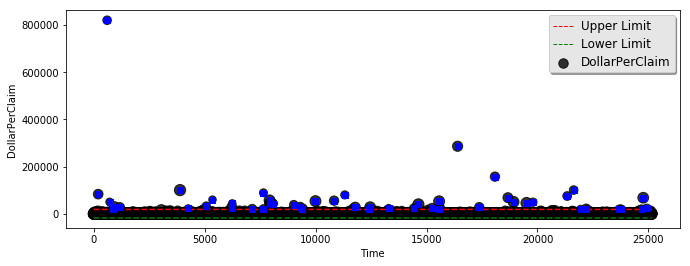

Number of above upper limit points =  49.0
Above upperlimit points: [201, 603, 719, 891, 929, 1174, 3890, 4255, 5074, 5353, 6221, 6244, 7145, 7641, 7650, 7926, 7930, 8088, 9017, 9298, 9403, 9994, 10833, 11316, 11785, 12418, 12458, 13297, 14425, 14634, 15248, 15567, 15582, 16401, 17377, 18084, 18669, 18923, 19507, 19794, 21339, 21632, 21941, 22196, 23696, 23767, 24691, 24768, 24931]


In [57]:
yName = "DollarPerClaim"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

count     25151.000000
mean        654.275655
std        5988.902911
min           0.010000
25%         147.265556
50%         313.160000
75%         573.108750
max      820177.040000
Name: DollarPerClaim, dtype: float64


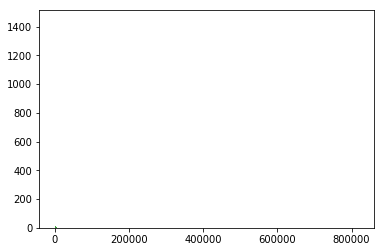

In [58]:
n, bins, patches = plt.hist(xd, bins='auto', facecolor='green', alpha=0.75)
print(xd.describe())

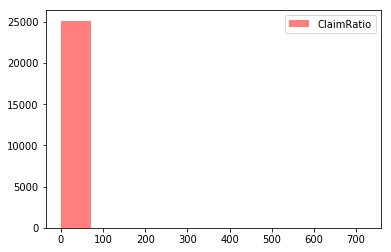

In [59]:
# box plot
plt.hist(np.array(modelData['ClaimRatio']), color=['r'], alpha=0.5, label='ClaimRatio')
plt.legend(loc='upper right')
plt.show()

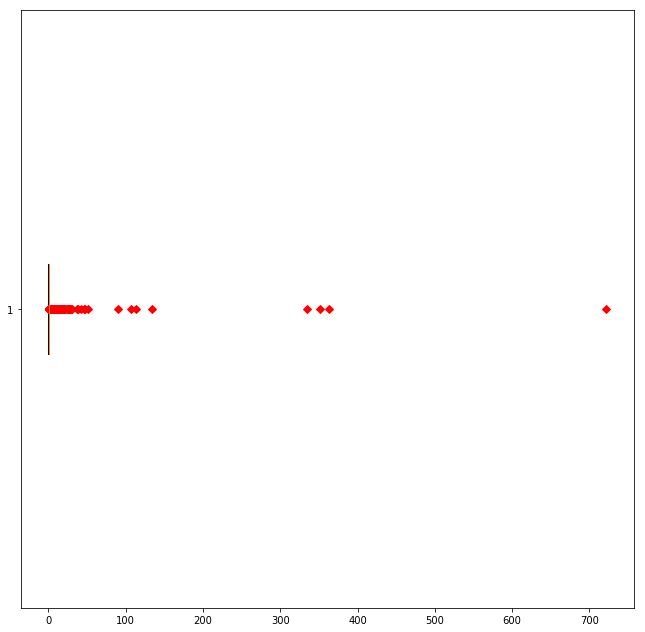

In [59]:
_plot_boxplot(np.array(modelData['ClaimRatio']))

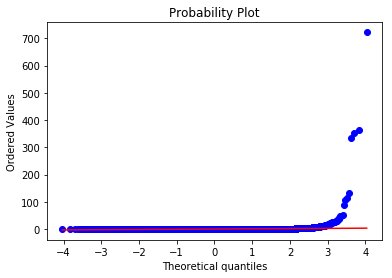

In [60]:
#series plot over three sigma
yName = "ClaimRatio"
ifactor = 3
xd = modelData[yName]
_plot_QQ(xd) 

In [60]:
import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)
#pd.set_option('display.width', 1000)

# Define inputs to model Claim Scoring

Possible Inputs:
- ClaimRatio
- DollarPerClaim ($/claim)

- DollarPerSale ($/sale)
- #Sales
- #Claims